# Hugging Face Molecular Biology Token Classification with BERT

In this colab, we'll be building a model which can identify molecular biology terms in a sentence. By the end of this colab, you'll have a model which can do this:

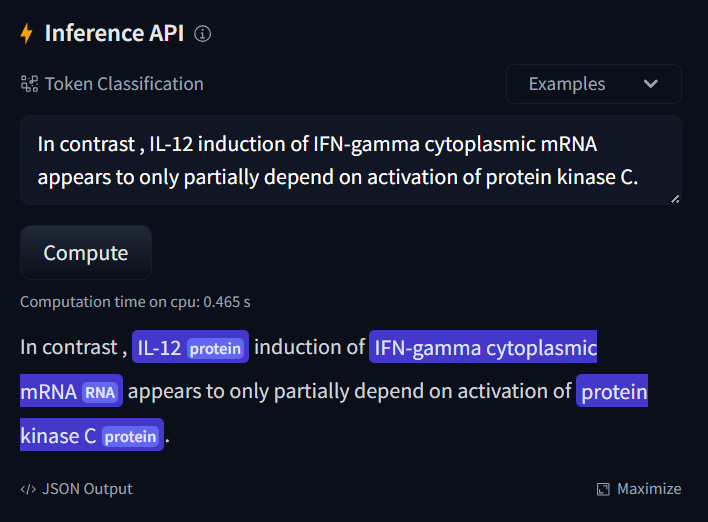

If you somehow came across this colab by accident, here's my corresponding article on Medium: https://medium.com/@raj.pulapakura/fine-tune-your-own-bert-token-classification-model-06b1153fbf56

# Install required libraries

In [1]:
!pip install transformers datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login

notebook_login()

# Regular Token Classifier

This standard token classifier is trained to identify People (`PER`), Locations (`LOC`), and Organizations (`ORG`).

In [3]:
from transformers import pipeline

token_classifier = pipeline(
    # task
    "token-classification",
    # model checkpoint
    "dbmdz/bert-large-cased-finetuned-conll03-english",
    # setting grouped_entities=True ensures that the model outputs will be grouped
    grouped_entities=True,
)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [4]:
token_classifier("My name is Raj, I live in Australia, and I love TensorFlow.")

[{'entity_group': 'PER',
  'score': 0.99407417,
  'word': 'Raj',
  'start': 11,
  'end': 14},
 {'entity_group': 'LOC',
  'score': 0.999833,
  'word': 'Australia',
  'start': 26,
  'end': 35},
 {'entity_group': 'ORG',
  'score': 0.9420502,
  'word': 'TensorFlow',
  'start': 48,
  'end': 58}]

# Explore the dataset

## Load dataset

For this task, we'll be using the `jnlpba` [dataset](https://huggingface.co/datasets/jnlpba).

In [6]:
from datasets import load_dataset

raw_datasets = load_dataset("jnlpba")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 18546
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3856
    })
})

In [8]:
label_names = raw_datasets["train"].features["ner_tags"].feature.names

label_names

['O',
 'B-DNA',
 'I-DNA',
 'B-RNA',
 'I-RNA',
 'B-cell_line',
 'I-cell_line',
 'B-cell_type',
 'I-cell_type',
 'B-protein',
 'I-protein']

In [9]:
example = raw_datasets["train"][0]

example

{'id': '1',
 'tokens': ['IL-2',
  'gene',
  'expression',
  'and',
  'NF-kappa',
  'B',
  'activation',
  'through',
  'CD28',
  'requires',
  'reactive',
  'oxygen',
  'production',
  'by',
  '5-lipoxygenase',
  '.'],
 'ner_tags': [1, 2, 0, 0, 9, 10, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0]}

The `tokens` are the words in the sentence, and the `ner_tags` are the corresponding labels.

NER stands for Named Entity Recognition.

In [13]:
print("Token => Label Name\n")

pre_length = 15
for token, ner_tag in zip(example["tokens"], example["ner_tags"]):
  ner_tag_label = label_names[ner_tag]
  string = token
  while len(string) != pre_length:
    string += " "
  print(f"{string} => {ner_tag_label}")

Token => Label Name

IL-2            => B-DNA
gene            => I-DNA
expression      => O
and             => O
NF-kappa        => B-protein
B               => I-protein
activation      => O
through         => O
CD28            => B-protein
requires        => O
reactive        => O
oxygen          => O
production      => O
by              => O
5-lipoxygenase  => B-protein
.               => O


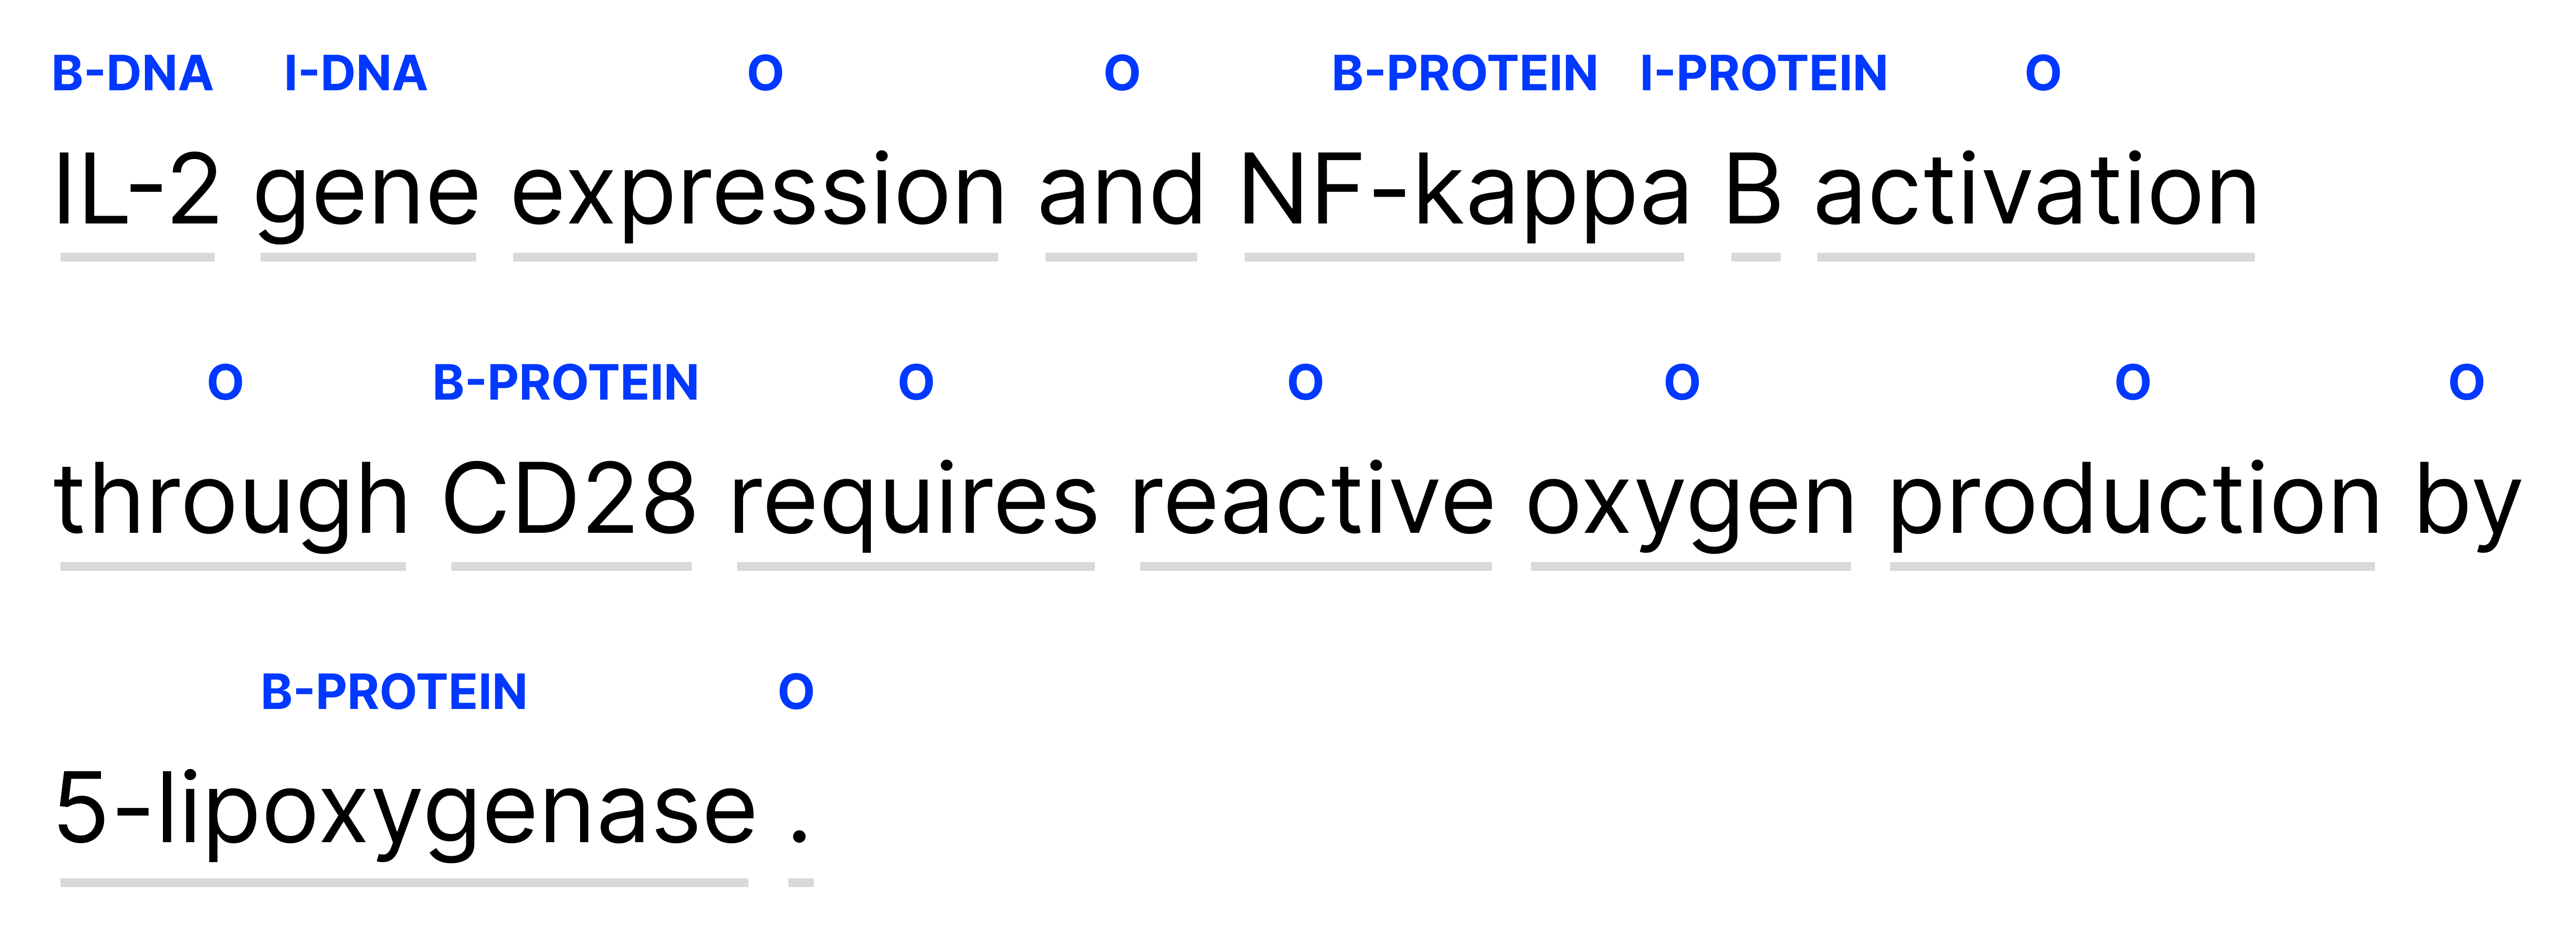

## Tokenization

The Tokenizer is used to convert sentences into [sub-words](https://towardsdatascience.com/a-comprehensive-guide-to-subword-tokenisers-4bbd3bad9a7c).

In [14]:
from transformers import AutoTokenizer

checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Let's tokenize our example.

In [66]:
example

<tf.Tensor: shape=(67,), dtype=int64, numpy=
array([  101,  3458,  2233,  5996,  1115,  4764, 10649,  1183,  4915,
        6530, 27154, 15792,  7571, 23162,   155,  2346,  2240,  3855,
        1134,  1173, 21497, 15393,   118,   123,  2838,  2258,   151,
        2271,   118, 24181, 13059,   139, 14915,   119,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])>

In [16]:
inputs = tokenizer(
    example["tokens"],
    is_split_into_words=True,
)

inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [18]:
print(inputs["input_ids"])

[101, 15393, 118, 123, 5565, 2838, 1105, 151, 2271, 118, 24181, 13059, 139, 14915, 1194, 2891, 24606, 5315, 26844, 7621, 1707, 1118, 126, 118, 4764, 10649, 1183, 4915, 6530, 119, 102]


Since the tokenizer converts the words into sub-words, the number of tokens will be greater than the number of labels, because each word has been split into one or more sub-words.

In [19]:
len(inputs["input_ids"])

31

In [20]:
len(example["ner_tags"])

16

Each token needs a corresponding label, so we need to "align" the labels with the tokens.

In [21]:
def align_labels_with_input_ids(word_ids, old_labels):
  """
  Returns new labels which are of the same length as the word ids.

  Example inputs:

  # word_ids = [None, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 14, 14, 14, 15, None]
  # labels = [1, 2, 0, 0, 9, 10, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0]

  Output:

  """

  new_labels = []
  prev_word_id = None

  for word_id in word_ids:
    if word_id is None:
      # if the word_id is None, i.e. the token is [CLS] or [SEP]
      new_labels.append(-100)
    else:
      label = old_labels[word_id]
      if prev_word_id == word_id and label % 2 == 1:
        # label is intermediate i.e. I-XXX
          label += 1
      new_labels.append(label)
    prev_word_id = word_id

  return new_labels

In [22]:
new_labels = align_labels_with_input_ids(inputs.word_ids(), example["ner_tags"])

In [24]:
len(inputs["input_ids"])

31

In [23]:
len(new_labels)

31

Nice, our labels are the same length as our input_ids!

In [25]:
print(new_labels)

[-100, 1, 2, 2, 2, 0, 0, 9, 10, 10, 10, 10, 10, 0, 0, 9, 10, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 10, 10, 0, -100]


Now, let's create a function which takes in a group of examples, tokenize each example, and aligns their labels.

In [26]:
def tokenize_and_align(examples):
  # tokenize examples
  model_inputs = tokenizer(
      examples["tokens"],
      truncation=True,
      is_split_into_words=True
  )

  # align labels
  model_inputs["labels"] = []
  # iterate over each example
  for i in range(len(model_inputs["input_ids"])):
    # get word_ids
    word_ids = model_inputs.word_ids(i)
    # get labels
    ner_tags = examples["ner_tags"][i]
    # compute new labels
    new_labels = align_labels_with_input_ids(word_ids, ner_tags)
    # store new labels
    model_inputs["labels"].append(new_labels)

  return model_inputs

Let's try this function on a group of examples.

In [31]:
examples = raw_datasets["train"][:5]

In [33]:
inputs = tokenize_and_align(examples)

In [34]:
for ex_input_ids, ex_labels in zip(inputs["input_ids"], inputs["labels"]):
  print(f">>> Length of input_ids: {len(ex_input_ids)}")
  print(f">>> Length of labels: {len(ex_labels)}")
  print()

>>> Length of input_ids: 31
>>> Length of labels: 31

>>> Length of input_ids: 41
>>> Length of labels: 41

>>> Length of input_ids: 67
>>> Length of labels: 67

>>> Length of input_ids: 46
>>> Length of labels: 46

>>> Length of input_ids: 35
>>> Length of labels: 35



Nice! We have tokenized the sentences, and made sure that the labels for each sentence are the same length.

Notice how each separate example, however, is of different length. That's because we haven't applied **padding** yet, however we will take care of this later.

In [35]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/18546 [00:00<?, ? examples/s]

Map:   0%|          | 0/3856 [00:00<?, ? examples/s]

In [37]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 18546
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3856
    })
})

## Data Collation

Data Collation means taking our dataset and organanizing it in mini-batches.

You may have noticed that we haven't padded our dataset yet, as models require each tensor to be of equal length. Padding the entire dataset at once would be inefficient, as we would be padding each tensor to the length of the longest tensor in the dataset.

Instead, we can do this for each mini-batch, so each tensor is only padded up to the largest tensor in its mini-batch. This saves unnecessary RAM and computation.

The data collator takes care of this for us.

In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer,
                                                   return_tensors="tf")

Let's test out our data collator on a small batch.

In [41]:
batch_pre_collation = [ tokenized_datasets["train"][i] for i in range(5) ]

In [42]:
for example in batch_pre_collation:
  print(f">>> Length: {len(example['input_ids'])}")

>>> Length: 31
>>> Length: 41
>>> Length: 67
>>> Length: 46
>>> Length: 35


Right now, each example has a different length.

After we apply padding through the data collator, each example will have the length of the longest example in the mini-batch.

In [44]:
batch_collated = data_collator(batch_pre_collation)

In [46]:
for example in batch_collated["input_ids"]:
  print(f">>> Length: {len(example)}")

>>> Length: 67
>>> Length: 67
>>> Length: 67
>>> Length: 67
>>> Length: 67


In [47]:
batch_collated["input_ids"].shape

TensorShape([5, 67])

In [48]:
batch_collated["labels"].shape

TensorShape([5, 67])

## Prepare dataset for fine-tuning

Now that we've set up our data collator, let's apply it to our entire dataset.

HuggingFace has a nice `.to_tf_dataset()` method which converts a HuggingFace dataset into a TensorFlow `tf.data.Dataset()` dataset.

In [49]:
columns = ["attention_mask", "input_ids", "labels", "token_type_ids"]
batch_size = 16

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=columns,
    collate_fn=data_collator,
    batch_size=batch_size,
    shuffle=True,
)

tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=columns,
    collate_fn=data_collator,
    batch_size=batch_size,
    shuffle=False,
)

# Fine-tuning!

## Load `bert-base-cased` model

Before loading the model, let's create some maps which will be used to go back and forth between ids and labels.

In [50]:
id2label = { i:k for i, k in enumerate(label_names) }
label2id = { v:k for k, v in id2label.items() }

In [51]:
id2label

{0: 'O',
 1: 'B-DNA',
 2: 'I-DNA',
 3: 'B-RNA',
 4: 'I-RNA',
 5: 'B-cell_line',
 6: 'I-cell_line',
 7: 'B-cell_type',
 8: 'I-cell_type',
 9: 'B-protein',
 10: 'I-protein'}

In [52]:
label2id

{'O': 0,
 'B-DNA': 1,
 'I-DNA': 2,
 'B-RNA': 3,
 'I-RNA': 4,
 'B-cell_line': 5,
 'I-cell_line': 6,
 'B-cell_type': 7,
 'I-cell_type': 8,
 'B-protein': 9,
 'I-protein': 10}

Now let's load our model.

The reason we created those maps above is so that the Inference API on the Hugging Face website can show us the label names such as "DNA" and "protein" instead of the ids.

In [54]:
from transformers import TFAutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model knows how many classes there are because of the maps we provided earlier.

In [56]:
model.config.num_labels

11

In [57]:
assert model.config.num_labels == len(label_names)

## Prepare model

Let's set up the optimizer with a learning rate decay.

In [59]:
num_epochs = 3

In [60]:
from transformers import create_optimizer
import tensorflow as tf

num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

In [61]:
model.compile(optimizer=optimizer)

## PushToHubCallback

This callbacks tells HuggingFace to push the model to your HuggingFace profile while the model is training.

To make this work, ensure that you have connected your HuggingFace account to the notebook.

In [62]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(
    output_dir="bert-finetuned-ner-medical",
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/raj-p/bert-finetuned-ner-medical into local empty directory.


Download file tf_model.h5:   0%|          | 26.2k/411M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/411M [00:00<?, ?B/s]

## Train!

In [ ]:
model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=[callback],
    epochs=num_epochs
)

Epoch 1/3
1160/1160 [==============================] - 484s 402ms/step - loss: 0.3065 - val_loss: 0.2755
Epoch 2/3
1160/1160 [==============================] - 420s 362ms/step - loss: 0.1835 - val_loss: 0.2722
Epoch 3/3
1160/1160 [==============================] - 435s 375ms/step - loss: 0.1514 - val_loss: 0.2864


# Inference

Now that our model is ready, we can try it out using the nifty `pipeline` API.

In [63]:
from transformers import pipeline

classifier = pipeline(
    "token-classification",
    # use your account name instead of "raj-p"
    "raj-p/bert-finetuned-ner-medical",
    grouped_entities=True,
)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/431M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

All the layers of TFBertForTokenClassification were initialized from the model checkpoint at raj-p/bert-finetuned-ner-medical.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [64]:
input = "In contrast, IL-12 induction of IFN-gamma cytoplasmic mRNA appears to only partially depend on activation of protein kinase C."

In [65]:
classifier(input)

[{'entity_group': 'protein',
  'score': 0.9925425,
  'word': 'IL - 12',
  'start': 13,
  'end': 18},
 {'entity_group': 'RNA',
  'score': 0.9626391,
  'word': 'IFN - gamma cytoplasmic mRNA',
  'start': 32,
  'end': 58},
 {'entity_group': 'protein',
  'score': 0.9795227,
  'word': 'protein kinase C',
  'start': 109,
  'end': 125}]